In [26]:
import ipynb.fs.full.preProcessing as preProcess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import json
import seaborn as sns

DECISION TREE MODEL:

Models: DecisionTreeRegressor, AdaBoostRegressor, RandomForestRegressor
```
DEPTH = 5
models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=400, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=100, max_depth=DEPTH)
}
```

Output: Offence rate at time t (t in 2015, 2016 due to limited communities data)
Assumptions: The communities.csv contains the data for 2014, 2015 (assume constant across the span of 2-3 years)
Features input: 
1. All features from communities (with 2 extra features for distance) at t-1, housing price at t-1, egm at t-1, offence rate at t-1 
2. Only the top 20 features from communities with the highest NMI with offence rate at t-1, housing price at t-1, egm at t-1, offence rate at t-1 

Evaluation: 50 folds validation, and take the median of RMSE/ MSE

Results: Noted below

Conclusion:
For both features set, only adaboost performs better than re-use the offence rate at (t-1).
Features set 2 results in a lower RMSE for adaboost and random forest.

Result:
```
For features 1:
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 697426.027159028
RMSE of regressor : 835.120329157219
MSE of ada : 383065.340033446
RMSE of ada : 618.9163007242792
MSE of rf : 570348.7403033725
RMSE of rf : 755.1780375340123
```
For features 2:
```
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 687015.5763979282
RMSE of regressor : 828.81992487444
MSE of ada : 373469.0699750013
RMSE of ada : 611.1193833613015
MSE of rf : 515237.70031876455
RMSE of rf : 717.6376753858078
```

In [27]:
# Preparing the frame for training model
offences = preProcess.cleanedOffences
offences = offences.drop(columns=["Year ending", "Police Region", "Offence Count"])

communities = preProcess.cleanedCommunities
communities["Distance from Melbourne"] = np.sqrt(communities["Location_x"]**2 + communities["Location_y"]**2)
communities["Direction from Melbourne"] = np.arctan(communities["Location_x"]/ communities["Location_y"])

housingPrices = preProcess.cleanedHousingPrice
egm = preProcess.cleanedEgm


In [28]:
from sklearn.preprocessing import OneHotEncoder

modelData = offences[(offences["Year"] == 2015) | (offences["Year"] == 2016)]
modelData = pd.merge(left=modelData, right=communities, how="left", on="LGA")

for idx, row in modelData.iterrows():
    modelData.loc[idx, "Last Offence Rate"] = offences[(offences["LGA"] == row["LGA"]) 
                                            & (offences["Year"] == row["Year"] - 1)]["Rate per 100,000 population"].iloc[0]
    modelData.loc[idx, "Last Housing Price"] = housingPrices.loc[row["LGA"]][str(row["Year"] - 1)]
    modelData.loc[idx, "Last EGM"] = egm.loc[row["LGA"]][str(row["Year"] - 1)]


In [29]:

# One hot the LGA - Use inverse transform from the encoder to get back the lga

oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["LGA"]).reshape(-1, 1))
oneHotLGA = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["LGA"]).reshape(-1, 1))
                         .toarray())
modelData = modelData.join(oneHotLGA)
modelData = modelData.drop(columns=["LGA"])

modelData.columns = modelData.columns.astype('str')

modelData

,Year,"Rate per 100,000 population",Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),ARIA+ (avg),Commercial (km^2),Industrial (km^2),Residential (km^2),...,46,47,48,49,50,51,52,53,54,55
0,2016,7903.7,20.289781,84.535123,0.000000,0.000000,0.000000,0.008991,0.021552,0.605656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016,9375.1,19.419507,128.349256,0.000000,0.000000,0.000000,0.016543,0.213052,0.474939,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016,10864.1,14.544640,45.693749,0.000000,0.000000,0.000000,0.029054,0.067348,0.697212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016,7166.8,16.202194,65.887204,0.000000,0.000000,0.000000,0.010994,0.107162,0.366402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,11420.0,23.587200,599.996103,0.023828,0.037001,0.029642,0.016390,0.026318,0.094048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2015,11385.6,384.960766,23359.313312,2.687931,3.482185,3.087847,0.000074,0.000461,0.001773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,2015,6857.1,58.368445,2142.863230,0.331739,0.880712,0.598316,0.000394,0.002019,0.020584,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,2015,9876.3,179.410340,6720.196354,2.135649,2.837918,2.452597,0.000128,0.000423,0.002905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,2015,5198.3,94.497165,1652.413568,0.512327,0.704602,0.606605,0.000191,0.000432,0.016410,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Add the pca of all attributes (since decision tree doesn't deal with combinations of factor)
from sklearn.decomposition import PCA

sklearn_pca = PCA(n_components=1)
X = modelData.drop(columns=["Rate per 100,000 population", "Year"])
features_pca = sklearn_pca.fit_transform(X)

modelData["pca"] = features_pca
explained_var = sklearn_pca.explained_variance_ratio_
print("Variance explained by each PCA feature: ", explained_var)
print("Total explained: ", sum(explained_var))


Variance explained by each PCA feature:  [0.99988791]
Total explained:  0.9998879112235093


FEATURES 1

In [31]:
def getSplitAttributes(tree_rules: str):
    # Parsing the split attributes
    splitAtts = []
    AttRegex = r".*\|--- ([^<>=]*) [<>=].*"

    for line in tree_rules.split("\n"):
        # print(line)
        matchObj = re.match(AttRegex, line)
        if matchObj:
            att = matchObj.group(1)
            splitAtts.append(att)
            # print(att)
    return splitAtts

In [32]:
# Define models here
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor

DEPTH = 5

models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=400, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=100, max_depth=DEPTH),
    "gradBoost": GradientBoostingRegressor(n_estimators = 300,
        max_depth = 4,
        min_samples_split = 3,
        learning_rate = 0.01,
        loss = "squared_error")
}

RMSE null:  4424.3710330399135
RMSE null 2:  968.6797054066254
RMSE of  regressor : 1038.4144280076848
RMSE of  ada : 896.9046871180341
RMSE of  rf : 1167.8513946123235
RMSE of  gradBoost : 900.102539412082


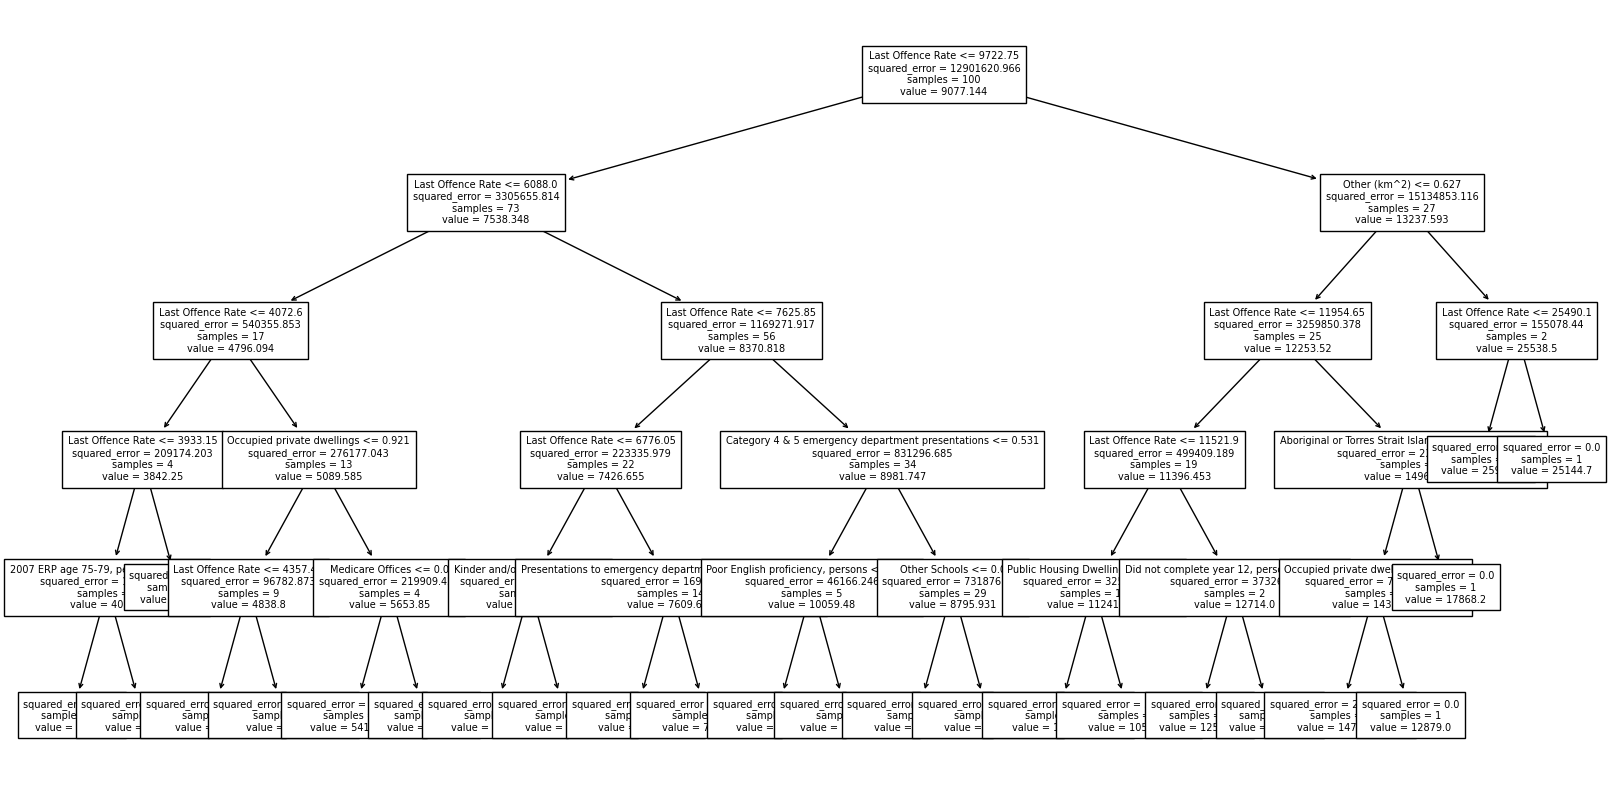

|--- Last Offence Rate <= 9722.75
|   |--- Last Offence Rate <= 6088.00
|   |   |--- Last Offence Rate <= 4072.60
|   |   |   |--- Last Offence Rate <= 3933.15
|   |   |   |   |--- 2007 ERP age 75-79, persons <= 0.03
|   |   |   |   |   |--- value: [4267.20]
|   |   |   |   |--- 2007 ERP age 75-79, persons >  0.03
|   |   |   |   |   |--- value: [4012.50]
|   |   |   |--- Last Offence Rate >  3933.15
|   |   |   |   |--- value: [3076.80]
|   |   |--- Last Offence Rate >  4072.60
|   |   |   |--- Occupied private dwellings <= 0.92
|   |   |   |   |--- Last Offence Rate <= 4357.45
|   |   |   |   |   |--- value: [4617.20]
|   |   |   |   |--- Last Offence Rate >  4357.45
|   |   |   |   |   |--- value: [4949.60]
|   |   |   |--- Occupied private dwellings >  0.92
|   |   |   |   |--- Medicare Offices <= 0.00
|   |   |   |   |   |--- value: [5412.67]
|   |   |   |   |--- Medicare Offices >  0.00
|   |   |   |   |   |--- value: [6377.40]
|   |--- Last Offence Rate >  6088.00
|   |   |--- L

In [33]:
# Use hold out for now
from sklearn.tree import plot_tree, export_text

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Models: https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/
# AdaBoost model (TODO: Recheck source): Train an initial tree with uniform weight for all points.
# Then, for subsequent iterations, change the weights so more weights are given for
# the points with errors.
# Then, random selection based on the normalized probability weights for the data points
# to construct a new datasets => Train a new tree on top of it 
# At the end, with 300 iterations, around 300 decision trees are built and used for regression


X = modelData.drop(columns=["Rate per 100,000 population", "Year"])
y = modelData["Rate per 100,000 population"]

# 19 random state yields some odd precision, likely due to how the split is constructed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=100)

predicts = {}

for name in models:
    model = models[name]
    models[name] = model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    predicts[name] = y_predict


y_null_predict = [y_train.mean()] * len(X_test)
y_null_2 = X_test["Last Offence Rate"]

mse_null = mean_squared_error(y_test, y_null_predict)
mse_null_2 = mean_squared_error(y_test, y_null_2)

print("RMSE null: ", np.sqrt(mse_null))
print("RMSE null 2: ", np.sqrt(mse_null_2))

for name in models:
    rmse = np.sqrt(mean_squared_error(predicts[name], y_test))
    print("RMSE of ", name, ":", rmse)



# Check the decision tree regressor
fig, axe = plt.subplots(figsize=(20,10))
plot_tree(models["regressor"], 
          feature_names=X_train.columns,
          ax=axe, 
          fontsize=7)
plt.show()

# Use text
tree_rules = export_text(models["regressor"], feature_names=list(X_train))
print(tree_rules)

print("Concise list of attributes")
print(pd.Series(getSplitAttributes(tree_rules)).value_counts())



MSE of null : 8166618.550165974
RMSE of null : 2855.8505224425808
MSE of null2 : 756750.2245454544
RMSE of null2 : 869.9025840950865
MSE of regressor : 1185260.1029797574
RMSE of regressor : 1081.6351714599705
MSE of ada : 622043.2067537392
RMSE of ada : 788.001712920201
MSE of rf : 1174183.0560735145
RMSE of rf : 1082.0338439105353
MSE of gradBoost : 726753.2745042673
RMSE of gradBoost : 852.4606529830871
Used attributes for regressor tree: 
Last Offence Rate                                                   200
Last Housing Price                                                   28
Last EGM                                                             12
TAFE students                                                        12
Public Housing Dwellings                                             12
IRSD (avg)                                                           10
pca                                                                  10
Distance from Melbourne                          

<Figure size 640x480 with 0 Axes>

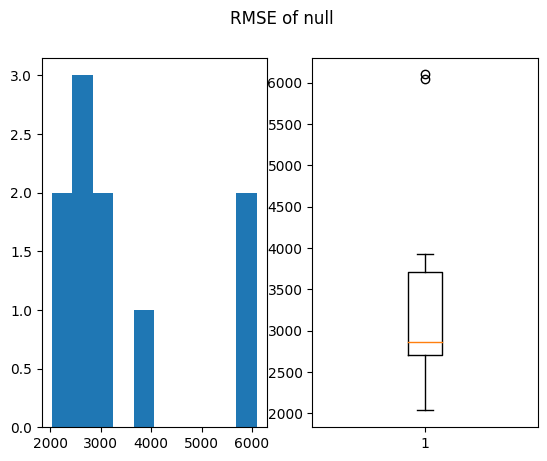

<Figure size 640x480 with 0 Axes>

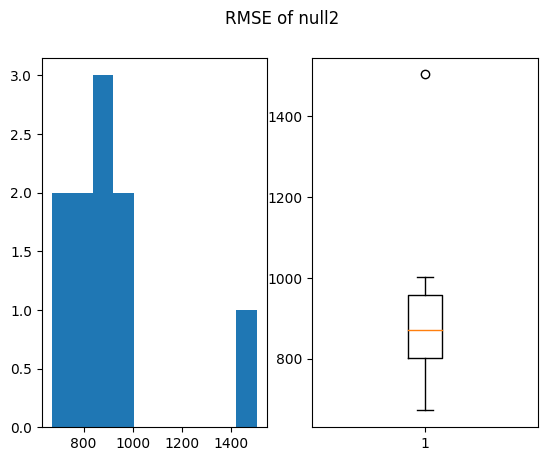

<Figure size 640x480 with 0 Axes>

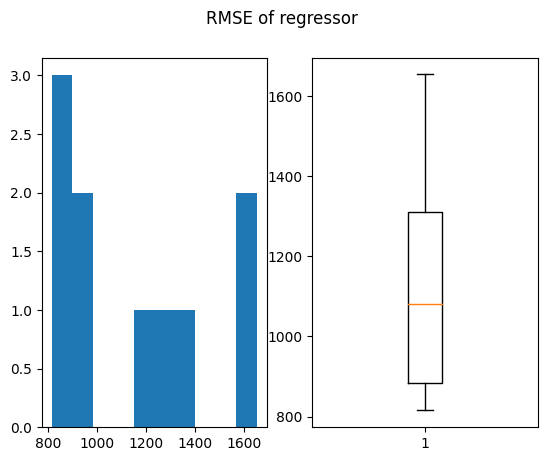

<Figure size 640x480 with 0 Axes>

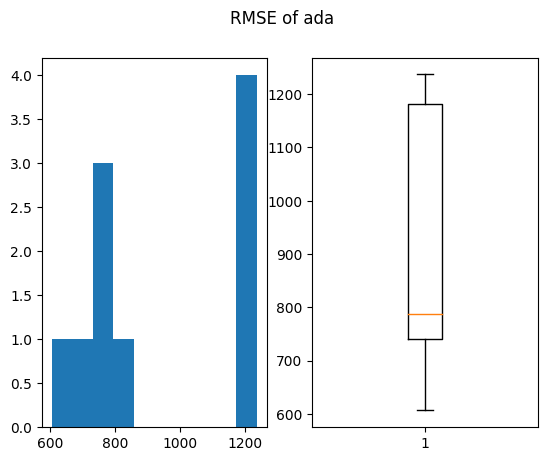

<Figure size 640x480 with 0 Axes>

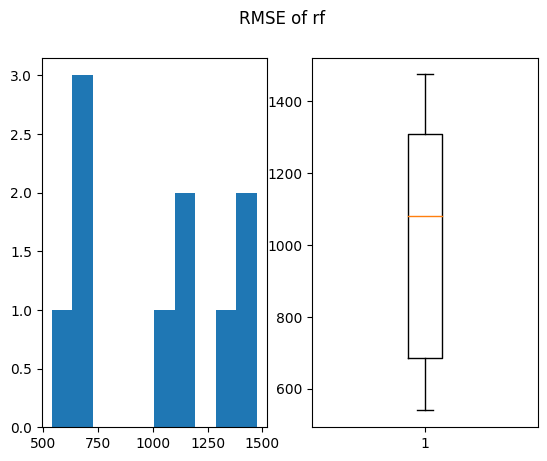

<Figure size 640x480 with 0 Axes>

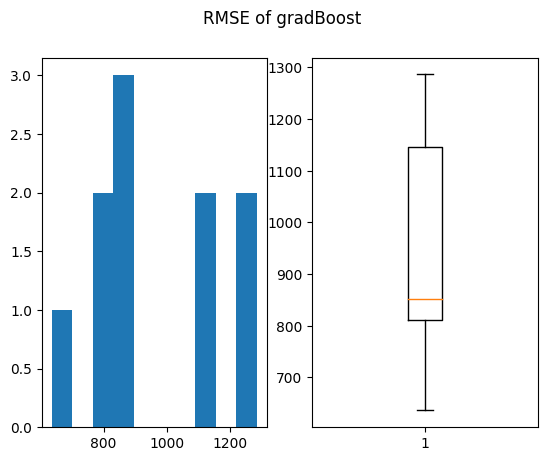

In [34]:
# K-fold, since the above is pretty random
from sklearn.model_selection import KFold

# Change to 50 for actual evaluation
# n = 50
n = 10

nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
mses = {
    "null": [],
    "null2": []
}

relavantAttributes = []


for train_idx, test_idx in nf_CV.split(X):
    # train-test split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_null_predict = [y_train.mean()] * len(X_test)
    y_null_2 = X_test["Last Offence Rate"]

    predicts = {}
    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    mse_null = mean_squared_error(y_test, y_null_predict)
    mse_null_2 = mean_squared_error(y_test, y_null_2)

    mses["null"].append(mse_null)
    mses["null2"].append(mse_null_2)

    for name in models:
        mse = mean_squared_error(predicts[name], y_test)
        if name not in mses:
            mses[name] = []
        mses[name].append(mse)


    # if (np.sqrt(mse_ada) > 2000):
    #     print(X_test)
    #     print(y_test)

    # Get the summary of all attributes
    tree_rules = export_text(models["regressor"], feature_names=list(X_train))
    relavantAttributes.extend(getSplitAttributes(tree_rules))

# Print the RMSE for each model
for key in mses:
    print("MSE of", key, ":", np.median(mses[key]))
    print("RMSE of", key, ":", np.median(np.sqrt(mses[key])))



print("Used attributes for regressor tree: ")
print(pd.Series(relavantAttributes).value_counts())

for name in mses:
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("RMSE of " + name)
    axs[0].hist(np.sqrt(mses[name]))
    axs[1].boxplot(np.sqrt(mses[name]))
    plt.show()
    

FEATURE 2: Pick the top 20 highest NMI score features only

In [35]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# Since most attribute uses the default discretiser, 
# this function will help with the NMI calculation
def getNMI(att1: np.array, att2: np.array, n_bins=5):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
    # Avoid the removal of bin by normalizing the data
    norm_att1 = (att1 - att1.min())/ (att1.max() - att1.min()) * 100
    norm_att2 = (att2 - att2.min())/ (att2.max() - att2.min()) * 100

    discrete_att1 = discretizer.fit_transform(norm_att1.reshape(-1, 1)).astype(int)
    discrete_att2 = discretizer.fit_transform(norm_att2.reshape(-1, 1)).astype(int)
    return normalized_mutual_info_score(discrete_att1.flatten(), discrete_att2.flatten())

def getTopNMICommunities(X_train, y_train):
    allScores = []
    for column in communities.columns:
        if column not in X_train.columns:
            continue
        score = getNMI(np.array(X_train[column]), np.array(y_train))
        allScores.append((column, score))
    allScores.sort(key=lambda x: -x[1])
    return [col[0] for col in allScores][:20]

d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose widt

MSE of null : 8166618.550165974
RMSE of null : 2855.8505224425808
MSE of null2 : 756750.2245454544
RMSE of null2 : 869.9025840950865
MSE of regressor : 1082635.2247005047
RMSE of regressor : 1038.58743655838
MSE of ada : 690085.9104464364
RMSE of ada : 827.0817227226901
MSE of rf : 1080054.8560686274
RMSE of rf : 1037.0576732021243
MSE of gradBoost : 739339.1976774595
RMSE of gradBoost : 859.6886530278679
Used attributes for regressor tree: 
Last Offence Rate                                    226
Last Housing Price                                    22
pca                                                   20
Public Housing Dwellings                              18
Last EGM                                              16
Male-headed lone parent families                      16
Presentations to emergency departments, 2012-13       14
IRSD (avg)                                            12
Female-headed lone parent families                    10
IRSD (min)                               

<Figure size 640x480 with 0 Axes>

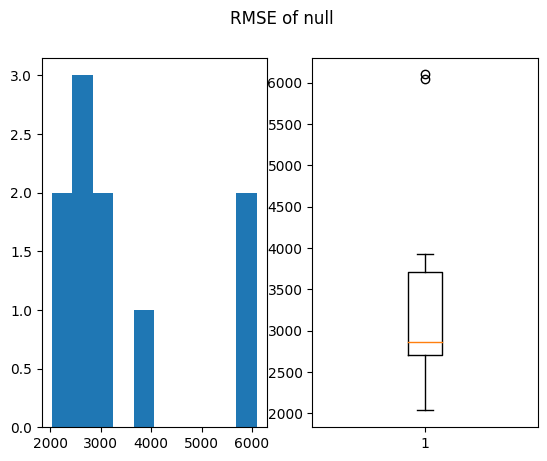

<Figure size 640x480 with 0 Axes>

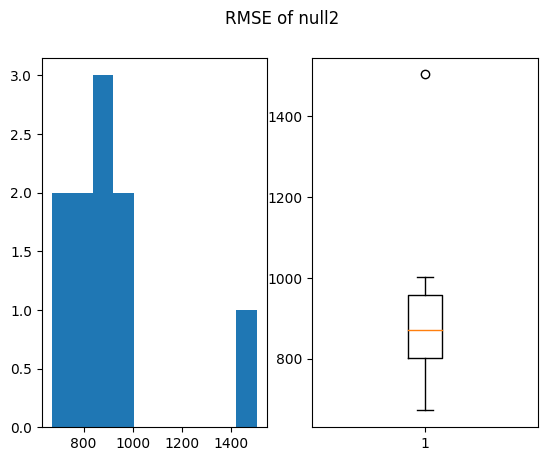

<Figure size 640x480 with 0 Axes>

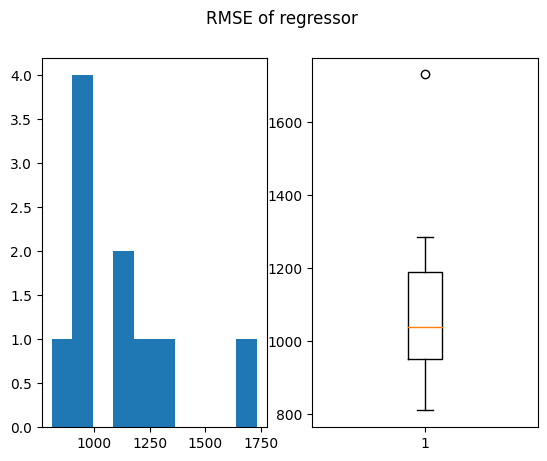

<Figure size 640x480 with 0 Axes>

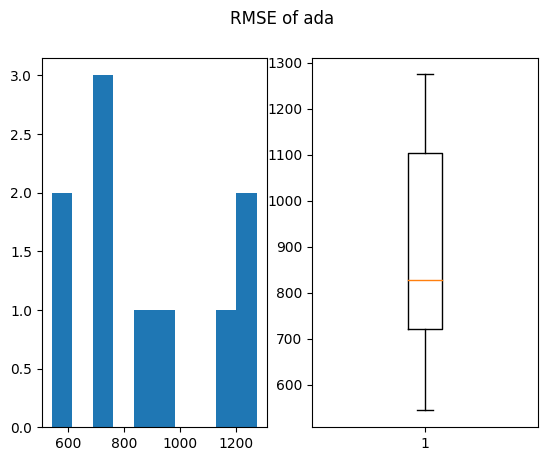

<Figure size 640x480 with 0 Axes>

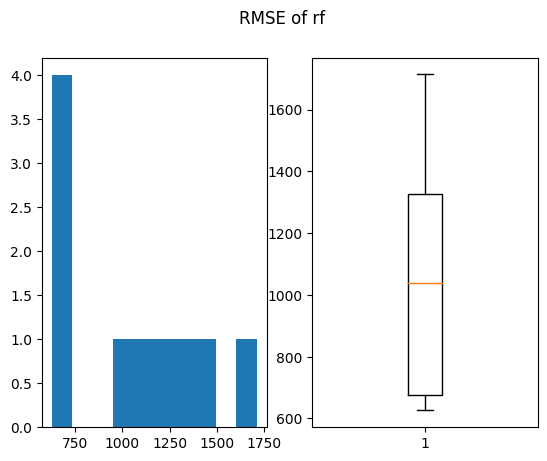

<Figure size 640x480 with 0 Axes>

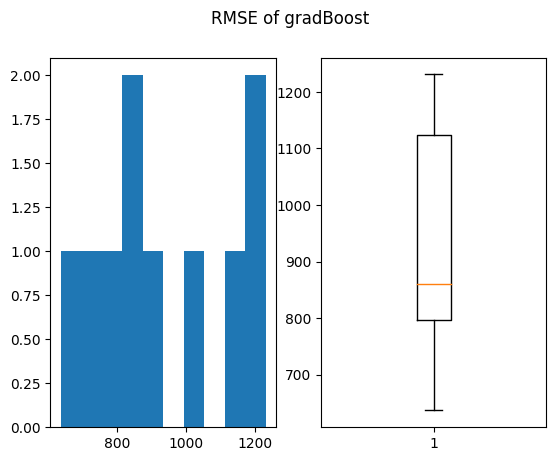

In [36]:
# Try restricting the input to only the top 10 highest NMI attribute from communities
from sklearn.model_selection import KFold

n = 10

nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
mses = {
    "null": [],
    "null2": []
}

relavantAttributes = []


for train_idx, test_idx in nf_CV.split(X):
    # train-test split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    top20Communities = getTopNMICommunities(X_train, y_train)
    dropCol = []
    for column in communities.columns:
        if column in X.columns and column not in top20Communities:
            dropCol.append(column)

    X_train = X_train.drop(columns=dropCol)
    X_test = X_test.drop(columns=dropCol)

    y_null_predict = [y_train.mean()] * len(X_test)
    y_null_2 = X_test["Last Offence Rate"]

    predicts = {}
    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    mse_null = mean_squared_error(y_test, y_null_predict)
    mse_null_2 = mean_squared_error(y_test, y_null_2)

    mses["null"].append(mse_null)
    mses["null2"].append(mse_null_2)

    for name in models:
        mse = mean_squared_error(predicts[name], y_test)
        if name not in mses:
            mses[name] = []
        mses[name].append(mse)


    # if (np.sqrt(mse_ada) > 2000):
    #     print(X_test)
    #     print(y_test)

    # Get the summary of all attributes
    tree_rules = export_text(models["regressor"], feature_names=list(X_train))
    relavantAttributes.extend(getSplitAttributes(tree_rules))

# Print the RMSE for each model
for key in mses:
    print("MSE of", key, ":", np.median(mses[key]))
    print("RMSE of", key, ":", np.median(np.sqrt(mses[key])))



print("Used attributes for regressor tree: ")
print(pd.Series(relavantAttributes).value_counts())



for name in mses:
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("RMSE of " + name)
    axs[0].hist(np.sqrt(mses[name]))
    axs[1].boxplot(np.sqrt(mses[name]))
    plt.show()


    

FEATURE 3: 

Ignore communities, and try to fit with EGM, housing and past offence alone

In [37]:
from sklearn.preprocessing import OneHotEncoder

modelData = offences[(offences["Year"] >= 2015) & (offences["Year"] <= 2021)]
modelData = pd.merge(left=modelData, right=communities, how="left", on="LGA")

for idx, row in modelData.iterrows():
    modelData.loc[idx, "Last Offence Rate"] = offences[(offences["LGA"] == row["LGA"]) 
                                            & (offences["Year"] == row["Year"] - 1)]["Rate per 100,000 population"].iloc[0]
    modelData.loc[idx, "Last Housing Price"] = housingPrices.loc[row["LGA"]][str(row["Year"] - 1)]
    modelData.loc[idx, "Last EGM"] = egm.loc[row["LGA"]][str(row["Year"] - 1)]

# Drop all except the time series one
dropCol = [col for col in modelData.columns if col not in ["Last Offence Rate", "Last Housing Price", 
                                                           "Last EGM", "LGA"]]
modelData = modelData.drop(columns=dropCol)


# One hot the LGA - Use inverse transform from the encoder to get back the lga

oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["LGA"]).reshape(-1, 1))
oneHotLGA = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["LGA"]).reshape(-1, 1))
                         .toarray())
modelData = modelData.join(oneHotLGA)
modelData = modelData.drop(columns=["LGA"])

modelData.columns = modelData.columns.astype('str')

modelData


,Last Offence Rate,Last Housing Price,Last EGM,0,1,2,3,4,5,6,...,46,47,48,49,50,51,52,53,54,55
0,7257.4,1.005577e+06,4.248559e+07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9899.5,6.758560e+05,1.019742e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10020.0,1.062963e+06,5.694230e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6119.1,8.938082e+05,3.461166e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9026.3,7.308673e+05,8.593511e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,11044.5,1.874375e+05,2.470024e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,6183.6,3.395000e+05,1.030988e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,7947.7,1.587500e+05,1.035065e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,4886.7,6.456000e+05,2.855820e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Define models here
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor


DEPTH = 5

models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=300, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=100, max_depth=DEPTH),
    "gradBoost": GradientBoostingRegressor(n_estimators = 300,
        max_depth = 4,
        min_samples_split = 3,
        learning_rate = 0.01,
        loss = "squared_error")
}

MSE of null : 8166618.550165974
RMSE of null : 2855.8505224425808
MSE of null2 : 756750.2245454544
RMSE of null2 : 869.9025840950865
MSE of regressor : 1185260.1029797574
RMSE of regressor : 1081.6351714599705
MSE of ada : 616524.6400131786
RMSE of ada : 784.2860978916983
MSE of rf : 1242598.0257384407
RMSE of rf : 1110.2133134966155
MSE of gradBoost : 730272.5897047336
RMSE of gradBoost : 854.4479969495899
Used attributes for regressor tree: 
Last Offence Rate                                                   200
Last Housing Price                                                   28
Last EGM                                                             12
TAFE students                                                        12
Public Housing Dwellings                                             12
IRSD (avg)                                                           10
pca                                                                  10
Distance from Melbourne                         

<Figure size 640x480 with 0 Axes>

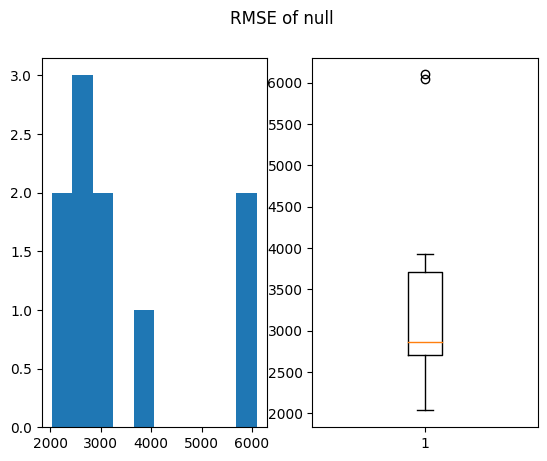

<Figure size 640x480 with 0 Axes>

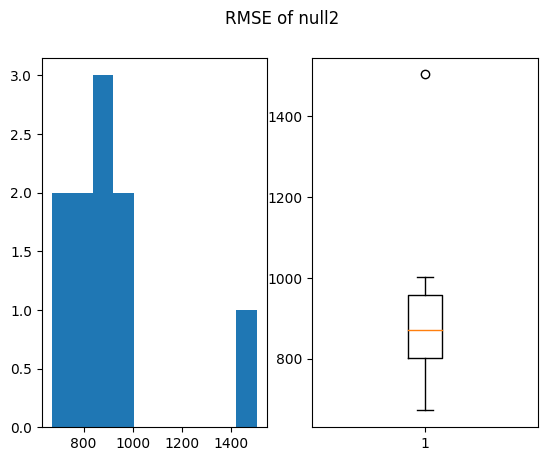

<Figure size 640x480 with 0 Axes>

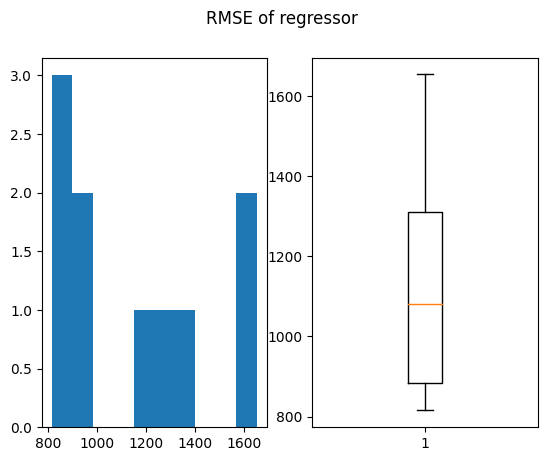

<Figure size 640x480 with 0 Axes>

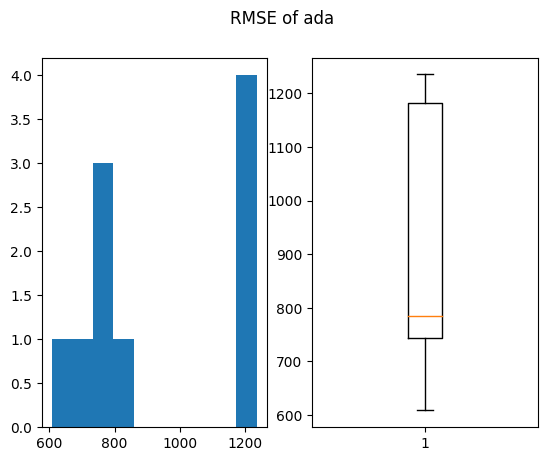

<Figure size 640x480 with 0 Axes>

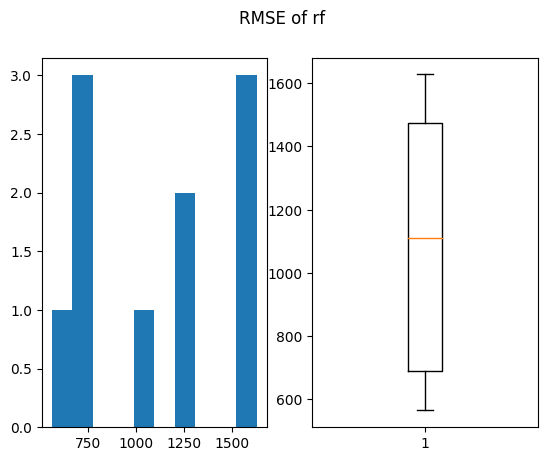

<Figure size 640x480 with 0 Axes>

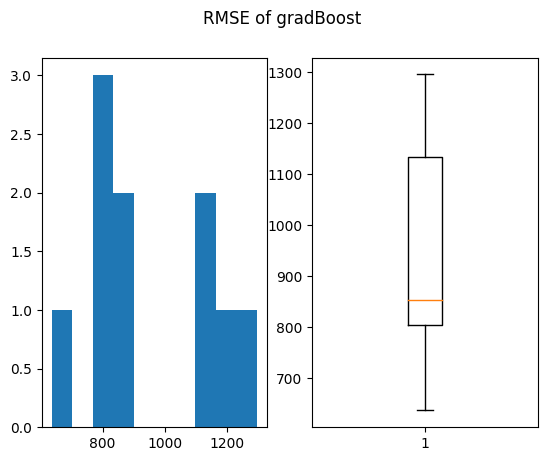

In [39]:
# Try restricting the input to only the top 10 highest NMI attribute from communities
from sklearn.model_selection import KFold

n = 10

nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
mses = {
    "null": [],
    "null2": []
}

relavantAttributes = []


for train_idx, test_idx in nf_CV.split(X):
    # train-test split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_null_predict = [y_train.mean()] * len(X_test)
    y_null_2 = X_test["Last Offence Rate"]

    predicts = {}
    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    mse_null = mean_squared_error(y_test, y_null_predict)
    mse_null_2 = mean_squared_error(y_test, y_null_2)

    mses["null"].append(mse_null)
    mses["null2"].append(mse_null_2)

    for name in models:
        mse = mean_squared_error(predicts[name], y_test)
        if name not in mses:
            mses[name] = []
        mses[name].append(mse)


    # if (np.sqrt(mse_ada) > 2000):
    #     print(X_test)
    #     print(y_test)

    # Get the summary of all attributes
    tree_rules = export_text(models["regressor"], feature_names=list(X_train))
    relavantAttributes.extend(getSplitAttributes(tree_rules))

# Print the RMSE for each model
for key in mses:
    print("MSE of", key, ":", np.median(mses[key]))
    print("RMSE of", key, ":", np.median(np.sqrt(mses[key])))



print("Used attributes for regressor tree: ")
print(pd.Series(relavantAttributes).value_counts())



for name in mses:
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("RMSE of " + name)
    axs[0].hist(np.sqrt(mses[name]))
    axs[1].boxplot(np.sqrt(mses[name]))
    plt.show()


    